# Clasificación de series de tiempo con RNN y LSTM
Este notebook entrena y compara dos modelos:
- RNN simple (`SimpleRNN`)
- LSTM


## 1) Cargar dataset procesado

In [1]:
DATASET = 'C:/Users/kevin/Github/Tarea_IA_2/data/data_processed.npz'

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import os



In [3]:
data = np.load(DATASET, allow_pickle=True)
X = data['X']
y = data['y']
classes = list(data['classes'])
n_classes = len(classes)
print(X.shape, y.shape, classes)

(396, 128, 3) (396,) [np.str_('caminando'), np.str_('correr'), np.str_('girando'), np.str_('quieto'), np.str_('saltar')]


## 2) Split train/val/test

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
X_train.shape, X_val.shape, X_test.shape

((277, 128, 3), (59, 128, 3), (60, 128, 3))

## 3) Construcción de modelos (RNN y LSTM)

In [5]:
input_shape = X_train.shape[1:]

def build_rnn(input_shape, n_classes):
    inp = keras.Input(shape=input_shape)
    x = layers.SimpleRNN(64, return_sequences=False)(inp)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inp, out, name='SimpleRNN_Classifier')
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_lstm(input_shape, n_classes):
    inp = keras.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=False)(inp)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inp, out, name='LSTM_Classifier')
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

rnn_model = build_rnn(input_shape, n_classes)
lstm_model = build_lstm(input_shape, n_classes)

rnn_model.summary()
lstm_model.summary()

Model: "SimpleRNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,677 (18.27 KB)

 Trainable params: 4,677 (18.27 KB)

 Non-trainable params: 0 (0.00 B)

Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,733 (69.27 KB)

 Trainable params: 17,733 (69.27 KB)

 Non-trainable params: 0 (0.00 B)

## 4) Entrenamiento

In [6]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
]
EPOCHS = 60
BATCH = 64

hist_rnn = rnn_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=EPOCHS, batch_size=BATCH, callbacks=callbacks, verbose=2)

hist_lstm = lstm_model.fit(X_train, y_train,
                           validation_data=(X_val, y_val),
                           epochs=EPOCHS, batch_size=BATCH, callbacks=callbacks, verbose=2)

Epoch 1/60
5/5 - 1s - 190ms/step - accuracy: 0.1841 - loss: 1.8577 - val_accuracy: 0.2373 - val_loss: 1.7771
Epoch 2/60
5/5 - 0s - 25ms/step - accuracy: 0.1877 - loss: 1.6878 - val_accuracy: 0.2034 - val_loss: 1.7439
Epoch 3/60
5/5 - 0s - 21ms/step - accuracy: 0.2491 - loss: 1.6270 - val_accuracy: 0.2542 - val_loss: 1.7187
Epoch 4/60
5/5 - 0s - 23ms/step - accuracy: 0.2563 - loss: 1.6238 - val_accuracy: 0.2373 - val_loss: 1.6988
Epoch 5/60
5/5 - 0s - 22ms/step - accuracy: 0.2708 - loss: 1.6197 - val_accuracy: 0.2373 - val_loss: 1.6804
Epoch 6/60
5/5 - 0s - 21ms/step - accuracy: 0.2888 - loss: 1.5961 - val_accuracy: 0.2373 - val_loss: 1.6454
Epoch 7/60
5/5 - 0s - 20ms/step - accuracy: 0.2744 - loss: 1.5750 - val_accuracy: 0.2542 - val_loss: 1.6131
Epoch 8/60
5/5 - 0s - 21ms/step - accuracy: 0.3105 - loss: 1.5061 - val_accuracy: 0.2542 - val_loss: 1.6024
Epoch 9/60
5/5 - 0s - 18ms/step - accuracy: 0.3213 - loss: 1.5332 - val_accuracy: 0.2881 - val_loss: 1.5752
Epoch 10/60
5/5 - 0s - 21ms

## 5) Evaluación y comparación

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
SimpleRNN — accuracy: 0.38333333333333336
              precision    recall  f1-score   support

   caminando     0.2000    0.1667    0.1818        12
      correr     0.4545    0.4167    0.4348        12
     girando     0.1667    0.1667    0.1667        12
      quieto     0.8000    1.0000    0.8889        12
      saltar     0.1667    0.1667    0.1667        12

    accuracy                         0.3833        60
   macro avg     0.3576    0.3833    0.3678        60
weighted avg     0.3576    0.3833    0.3678        60



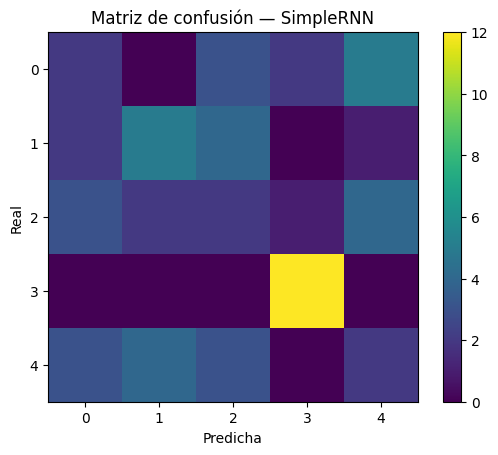

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
LSTM — accuracy: 0.3333333333333333
              precision    recall  f1-score   support

   caminando     0.3846    0.4167    0.4000        12
      correr     0.3462    0.7500    0.4737        12
     girando     0.6000    0.2500    0.3529        12
      quieto     0.0000    0.0000    0.0000        12
      saltar     0.2000    0.2500    0.2222        12

    accuracy                         0.3333        60
   macro avg     0.3062    0.3333    0.2898        60
weighted avg     0.3062    0.3333    0.2898        60



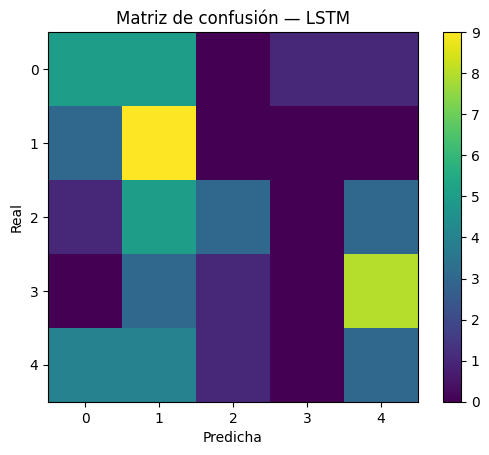

In [7]:
def evaluate(model, name):
    preds = model.predict(X_test)
    yhat = preds.argmax(axis=1)
    print(name, '— accuracy:', (yhat==y_test).mean())
    print(classification_report(y_test, yhat, target_names=classes, digits=4))
    cm = confusion_matrix(y_test, yhat)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Matriz de confusión — {name}')
    plt.xlabel('Predicha')
    plt.ylabel('Real')
    plt.colorbar()
    plt.show()
    return cm

cm_rnn = evaluate(rnn_model, 'SimpleRNN')
cm_lstm = evaluate(lstm_model, 'LSTM')

## 6) Guardado de modelos y mejores pesos

In [8]:
rnn_model.save('C:/Users/kevin/Github/Tarea_IA_2/model/model_rnn.keras')
lstm_model.save('C:/Users/kevin/Github/Tarea_IA_2/model/model_lstm.keras')
print('Modelos guardados.')

Modelos guardados.


## 7) Diagramas de los modelos y conteo de parámetros por capa
Se necesita instalar `pydot` y `graphviz` para visualizar los diagramas.

In [9]:
OUTPUT_DIR = r"C:\Users\kevin\Github\Tarea_IA_2\assets"
os.makedirs(OUTPUT_DIR, exist_ok=True)

plot_model(rnn_model, to_file=os.path.join(OUTPUT_DIR, "rnn_diagram.png"), show_shapes=True, dpi=96)
plot_model(lstm_model, to_file=os.path.join(OUTPUT_DIR, "lstm_diagram.png"), show_shapes=True, dpi=96)

print("Diagramas guardados en:", OUTPUT_DIR)

Diagramas guardados en: C:\Users\kevin\Github\Tarea_IA_2\assets


### Fórmulas de parámetros (para tu informe)
- **SimpleRNN(units, input_dim)**: parámetros = `units*(units + input_dim + 1)`
- **LSTM(units, input_dim)**: parámetros = `4*units*(units + input_dim + 1)`
- **Dense(units, prev_units)**: parámetros = `prev_units*units + units` (bias)

A continuación calculamos automáticamente por capa:

In [10]:
def layer_param_table(model):
    rows = []
    for layer in model.layers:
        rows.append({
            'layer': layer.name,
            'class': layer.__class__.__name__,
            'output_shape': tuple(layer.output_shape) if hasattr(layer, 'output_shape') else None,
            'params': layer.count_params(),
        })
    return pd.DataFrame(rows)

df_rnn = layer_param_table(rnn_model)
df_lstm = layer_param_table(lstm_model)
print('RNN params by layer:')
display(df_rnn)
print('LSTM params by layer:')
display(df_lstm)
print('Total RNN:', rnn_model.count_params(), '| Total LSTM:', lstm_model.count_params())

RNN params by layer:


,layer,class,output_shape,params
0,input_layer,InputLayer,None,0
1,simple_rnn,SimpleRNN,None,4352
2,dropout,Dropout,None,0
3,dense,Dense,None,325


LSTM params by layer:


,layer,class,output_shape,params
0,input_layer_1,InputLayer,None,0
1,lstm,LSTM,None,17408
2,dropout_1,Dropout,None,0
3,dense_1,Dense,None,325


Total RNN: 4677 | Total LSTM: 17733


## 8) Exportar métricas claves

In [12]:
def export_metrics(model, name):
    preds = model.predict(X_test).argmax(axis=1)
    rep = classification_report(y_test, preds, target_names=classes, output_dict=True)
    dfm = pd.DataFrame(rep).T
    out = f'C:/Users/kevin/Github/Tarea_IA_2/data/metrics_{name}.csv'
    dfm.to_csv(out)
    print('Guardado', out)
export_metrics(rnn_model, 'rnn')
export_metrics(lstm_model, 'lstm')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Guardado C:/Users/kevin/Github/Tarea_IA_2/data/metrics_rnn.csv
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Guardado C:/Users/kevin/Github/Tarea_IA_2/data/metrics_lstm.csv
